Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


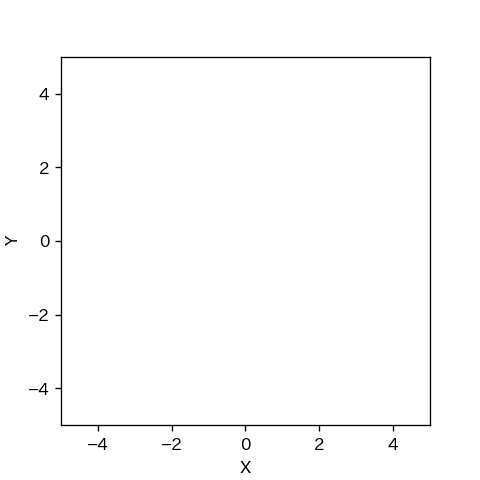

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


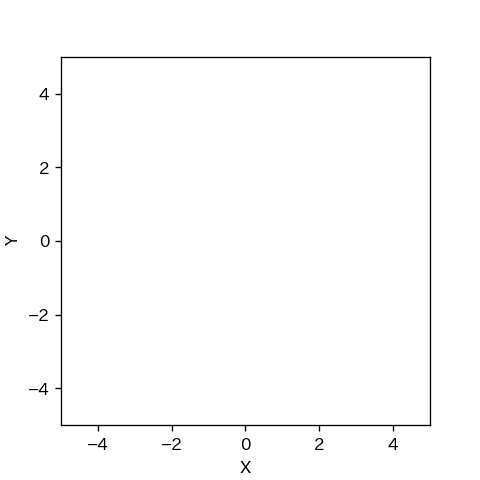

(array([-2.31036933, -2.66767379,  1.21415128]),
 array([ 2.61315231, -0.96769369,  0.68442726]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[5.7344080576869345]
[2.994505751829771]
0 真値: [ 0.17236561 -3.70108541  7.60879431] 推定値: [ 2.37278628 -1.2940242  -0.78166183] 誤差: 3.2612566275533226
[5.152381906237041]
1 真値: [-4.19023032  1.65501255  5.59601014] 推定値: [-4.25623343  1.58193785  5.77084035] 誤差: 0.09846991542022915
1
[5.770768096133537]
2 真値: [-4.37424716 -3.39903433  3.71803448] 推定値: [-3.70331458 -3.89264999  3.51389961] 誤差: 0.832950742993282
2
[1.0461870054233726]
3 真値: [-0.57730644 -3.38591795  4.996812  ] 推定値: [-0.2756115  -2.61088031  4.86244544] 誤差: 0.8316869453524027
3
[6.560515232508461]
[5.931939520771369, 4.836289515337769]
4 真値: [-3.08190553 -3.31452682  7.07212048] 推定値: [-3.39238843 -3.37129309  0.72442201] 誤差: 0.31562959608713637
4
[3.9220876433111806]
5 真値: [ 2.96002858 -0.03148672  4.93836388] 推定値: [ 4.94656441 -2.63446529 -2.45302107] 誤差: 3.274419342743824
[1.1190848720725681]
[5.6434029478564325]
6 真値: [ 1.00039147 -2.21069827  3.45910686] 推定値: [4.13270865 8.50130759 0.30740265] 誤差: 11.160577065914637
[

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-3.69577976  1.51722372  4.03686303] 推定値: [-3.66765067  1.63985405  4.52686303] 誤差: 0.1258151177117256
15
[4.185951476192619]
21 真値: [ 1.89761401 -1.81418551  6.03700821] 推定値: [ 1.53477334 -1.84224941  6.21026444] 誤差: 0.36392435911555204
16
[2.820285771985372]
22 真値: [1.56684579 2.0761959  4.22655714] 推定値: [0.75148692 2.90219512 4.2234622 ] 誤差: 1.1606398243303635
[0.6077891896151737]
23 真値: [2.9015337  1.97318258 7.30569073] 推定値: [3.09034815 2.04032558 7.53664928] 誤差: 0.20039730905450576
17
24 真値: [-4.14110569 -2.44510544  3.29093655] 推定値: [-3.68726943 -2.06747334  9.39565814] 誤差: 0.5904010109437411
18
25 真値: [ 4.12868869 -1.14895526  3.83645087] 推定値: [ 4.07978196 -0.8299923   3.88175561] 誤差: 0.322690623829227
19
[4.049807784541852, 5.888141123421528]
26 真値: [-2.33368421 -1.96228208  6.22096451] 推定値: [-2.45199011 -2.16807884  6.25255981] 誤差: 0.23737858657307898
20
[2.5376061150531104]
27 真値: [-0.47337842  2.51561974  8.47293269] 推定値: [0.00496488 3.07103324 2.05778097] 誤差: 0.733